In [1]:
using Pkg
Pkg.add("LightGraphs")
Pkg.add("TikzGraphs")
Pkg.add("Combinatorics")
Pkg.add("GraphPlot")
Pkg.add("Compose")
Pkg.add("LaTeXStrings")
Pkg.add("Hodge")

    Updating registry at `C:\Users\Rubén Bautista\.julia\registries\General`


    Updating git-repo `https://github.com/JuliaRegistries/General.git`


   Resolving package versions...


  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Manifest.toml`

   Resolving package versions...


  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Project.toml`
  No Changes to `C:\Users\Rubén Bautista\.julia\environments\v1.6\Manifest.toml`

   Resolving package versions...


   Installed Hodge ─ v0.1.0


    Updating `C:\Users\Rubén Bautista\.julia\environments\v1.6\Project.toml`
 

 [3c44080d] + Hodge v0.1.0
    Updating `C:\Users\Rubén Bautista\.julia\environments\v1.6\Manifest.toml`
  [3c44080d] + Hodge v0.1.0


Precompiling

project...


  ✓ Hodge
  1 dependency successfully precompiled in 5 seconds (81 already precompiled)

In [2]:
using LightGraphs
using TikzGraphs
using Combinatorics
using GraphPlot
using LaTeXStrings
using Hodge

In [3]:
# n is the value of the labels, i.e, the n of T_n
function get_splits(n)
    rng = 0:n
    rng_set = Set(rng)
    # We use sets because with this approach is almost sure that we are generating duplicated splits
    needed_subsets = map(dim -> map(Set, Combinatorics.combinations(rng, dim)), 2:ceil(Int, (n+1)/2))
    splits = Set(map(subset -> Set([subset, symdiff(rng_set, subset)]), Iterators.flatten(needed_subsets)))
    return splits
end

get_splits (generic function with 1 method)

In [4]:
function compatible_splits(split_1, split_2)
    X_1, Y_1 = collect(split_1)
    X_2, Y_2 = collect(split_2)
    X_1_X_2 = intersect(X_1, X_2)
    X_1_Y_2 = intersect(X_1, Y_2)
    X_2_Y_1 = intersect(X_2, Y_1)
    Y_1_Y_2 = intersect(Y_1, Y_2)
    if length(X_1_X_2) == 0 || length(X_1_Y_2) == 0 || length(X_2_Y_1) == 0 || length(Y_1_Y_2) == 0
        return true
    end
    return false
end

function generate_raw_simplicial_complex(splits)
    table_of_compatibility = Dict()
    s_complex = Dict()
    vertex_combinations = Set(collect(Combinatorics.combinations(collect(splits), 2)))
    for vertex_combination in vertex_combinations
        split_1, split_2 = vertex_combination
        push!(table_of_compatibility, Set(vertex_combination) => compatible_splits(split_1, split_2))
    end
    # First we add the vertices to the complex
    push!(s_complex, 0 => Set(map(split -> Set([split]) , collect(splits))))
    # Now we iterate through dimensions
    previous_dimension = 0
    added_simplices = true
    while added_simplices
        added_simplices = false
        current_dimension = previous_dimension + 1
        current_dimension_simplices = []
        for split in splits
            for simplex in s_complex[previous_dimension]
                if !(split in simplex)
                    all_compatible = true
                    for vertex in simplex
                        if !table_of_compatibility[Set([split, vertex])]
                            all_compatible = false
                            break
                        end
                    end
                    if all_compatible
                        added_simplices = true
                        new_simplex = union(simplex, Set([split]))
                        push!(current_dimension_simplices, new_simplex)
                    end
                end
            end
        end
        if added_simplices
            push!(s_complex, current_dimension => Set(current_dimension_simplices))
        end
        previous_dimension = current_dimension
    end
    return s_complex
end

generate_raw_simplicial_complex (generic function with 1 method)

In [5]:
function generate_abstract_simplicial_complex(simplicial_complex_raw)
    dim_complex = length(simplicial_complex_raw) - 1
    simplicial_complex = Dict()
    map_vertices_to_integers = Dict(
            map(enumerated_split -> (collect(enumerated_split[2])[1], enumerated_split[1]),
            enumerate(simplicial_complex_raw[0])))
    for dim in 0:dim_complex
        simplices = []
        simplices_raw = simplicial_complex_raw[dim]
        for simplex_raw in simplices_raw
            simplex = []
            for vertex in simplex_raw
                push!(simplex, map_vertices_to_integers[vertex])
            end
            push!(simplices, Set(simplex))
        end
        push!(simplicial_complex, dim => Set(simplices))
    end
    return simplicial_complex
end

generate_abstract_simplicial_complex (generic function with 1 method)

In [6]:
function get_graph_from_simplicial_complex(simplicial_complex)
    graph = LightGraphs.SimpleGraph(length(simplicial_complex[0]))
    for edge in simplicial_complex[1]
        e_1, e_2 = collect(edge)
        add_edge!(graph, e_1, e_2)
    end
    return graph
end

get_graph_from_simplicial_complex (generic function with 1 method)

In [7]:
function get_info_tree_n_from_simplicial_complex(simplicial_complex)
    dim = length(keys(simplicial_complex)) - 1
    println("Dimension of the simplicial complex: $dim")
    vertices = length(simplicial_complex[0])
    println("Number of vertices: $vertices")
    if dim >= 1
        edges = length(simplicial_complex[1])
        println("Number of edges: $edges")
    end
    if dim >= 2
        triangles = length(simplicial_complex[2])
        println("Number of triangles: $triangles")
    end
end

get_info_tree_n_from_simplicial_complex (generic function with 1 method)

In [30]:
function get_simplicial_complex_without_dims(simplicial_complex_with_dims)
    s_complex = []
    for dim in keys(simplicial_complex_with_dims)
        append!(s_complex, map(s_complex_dim -> collect(s_complex_dim), collect(simplicial_complex_with_dims[dim])))
    end
    return s_complex
end
function get_homology_information(simplicial_complex_with_dims)
    s_complex =SimplicialComplex(get_simplicial_complex_without_dims(simplicial_complex_with_dims))
    euler_c = euler_characteristic(s_complex)
    bettis = betti(s_complex)
    println("Euler characteristic: $euler_c")
    for dim in 0:(length(bettis)-1)
        betti_dim = bettis[dim+1]
        println("Betti number: $betti_dim")
    end
    
end

get_homology_information (generic function with 1 method)

In [8]:
splits_t_4 = get_splits(4)
s_complex_t_4_raw = generate_raw_simplicial_complex(splits_t_4)
s_complex_t_4 = generate_abstract_simplicial_complex(s_complex_t_4_raw)
graph_t_4 = get_graph_from_simplicial_complex(s_complex_t_4)

{10, 15} undirected simple Int64 graph

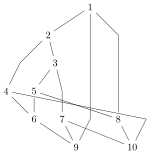

In [9]:
TikzGraphs.plot(graph_t_4)

In [10]:
splits_t_5 = get_splits(5)
s_complex_t_5_raw = generate_raw_simplicial_complex(splits_t_5)
s_complex_t_5 = generate_abstract_simplicial_complex(s_complex_t_5_raw)

Dict{Any, Any} with 3 entries:
  0 => Set(Any[Set(Any[20]), Set(Any[22]), Set(Any[16]), Set(Any[10]), Set(Any[…
  2 => Set(Any[Set(Any[20, 14, 3]), Set(Any[13, 4, 18]), Set(Any[5, 9, 24]), Se…
  1 => Set(Any[Set(Any[16, 24]), Set(Any[12, 24]), Set(Any[4, 12]), Set(Any[5, …

In [11]:
get_info_tree_n_from_simplicial_complex(s_complex_t_5)

Dimension of the simplicial complex: 2
Number of vertices: 25
Number of edges: 105
Number of triangles: 105


In [31]:
get_homology_information(s_complex_t_4)

Euler characteristic: -5
Betti number: 1
Betti number: 6


In [32]:
get_homology_information(s_complex_t_5)

Euler characteristic: 25
Betti number: 1
Betti number: 0
Betti number: 24
